In [5]:
import torch
from bert import *
from feature_data import *
from multiprototype import *
from models import *


We want to evaluate the model on its ability to predict features in context. First, we obtain gold vectors for both senses of 10 ambiguous words from the McRae et al. data

TODO: Ensure that the models are not trained on this data. Maybe train on everything but these words?

What are the words?

In [2]:


ambiguous_pairs = [
    ('bat_animal', 'bat_baseball'),
    ('board_wood', 'board_black'),
    ('bow_ribbon', 'bow_weapon'),
    ('cap_bottle', 'cap_hat'),
    #('crane_machine', 'crane_animal')
    ('hose', 'hose_leggings'),
    ('mink', 'mink_coat'), # this one is not fully disambiguated
    ('mouse', 'mouse_computer'),
    ('pipe_smoking', 'pipe_plumbing'),
    ('tank_army', 'tank_container')
]

# Train the Model

We train a 4 layer FFNN to predict the real-valued features of each word, using buchanan (2019) feature norms as training data. We exclude only the above words, and train on all the rest. 

In [3]:
[item for t in ambiguous_pairs for item in t]


['bat_animal',
 'bat_baseball',
 'board_wood',
 'board_black',
 'bow_ribbon',
 'bow_weapon',
 'cap_bottle',
 'cap_hat',
 'hose',
 'hose_leggings',
 'mink',
 'mink_coat',
 'mouse',
 'mouse_computer',
 'pipe_smoking',
 'pipe_plumbing',
 'tank_army',
 'tank_container']

In [8]:
"""
train a multiprototype model
"""
from argparse import Namespace


# initialize model

# dummy command line options
args = Namespace(epochs=30, 
                 lr=1e-3, 
                 dropout=0.2, 
                 layer = 8,
                 clusters = 5,
                 save_path= 'ffnn.30eps.5k.training4418.saved',
                 batch_size=1,
                 hidden_size = 300
                )

# x data
feature_norms = BuchananFeatureNorms('data/buchanan/cue_feature_words.csv')
# y_hat data
layer = 8
clusters = 5
embedding_file = './data/multipro_embeddings/layer'+ str(args.layer) + 'clusters' + str(args.clusters) + '.txt'
embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=args.clusters)



#train_words are all feature_norms except for the above words
#dev words are the above words
#test words are the above words
words = list(feature_norms.vocab.keys())
eval_words = [item for t in ambiguous_pairs for item in t]

print("Starting with %s words" % len(words))
train_words = [i for i in words if i not in eval_words]
print("Ending up with %s training words" % len(train_words))


# train
multi_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)


# save
torch.save(model, args.save_path)

Read in 12348 vectors of size 5 X 768
Starting with 4436 words
Ending up with 4418 training words
Initializing FFNN with input size 768, hidden size 300, output size 3981

Total loss on epoch 0: 47513340.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.7355583161953755
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.2509293690314514
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.35288481485129697
Average % @k (derby metric) 0.23972601705610588
correlation between gold and predicted vectors: 0.06342501220261743 
=======DEV SET=======
bat_animal
['lie', 'cover', 'wood', 'social', 'metal', 'on', 'sit', 'friend', 'wound', 'person']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 


Total loss on epoch 5: 39437364.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5936347321498622
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.3930737890448167
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5296253479126859
Average % @k (derby metric) 0.38542695709664826
correlation between gold and predicted vectors: 0.07433243163101617 
=======DEV SET=======
bat_animal
['electric', 'beef', 'food', 'wing', 'black', 'mail', 'eat', 'person', 'small', 'fly']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['irish', 'sound', 'money', 'person', 'salt', 'food', 'shy', 'black', 'fly', 'small', 'meat'


Total loss on epoch 11: 36369860.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5538141899034317
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.4348614434456444
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.564802530718212
Average % @k (derby metric) 0.43286630265376913
correlation between gold and predicted vectors: 0.0748043270036013 
=======DEV SET=======
bat_animal
['hold', 'precise', 'school', 'metal', 'food', 'fly', 'small', 'leg', 'animal', 'eat']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['meat', 'wheel', 'vegetable', 'second', 'black', 'correct', 'white', 'four', 'school', 'prec


Total loss on epoch 17: 34790096.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5340226261162696
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.44824877664963675
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5752344093496932
Average % @k (derby metric) 0.4534008880878926
correlation between gold and predicted vectors: 0.07496367417909712 
=======DEV SET=======
bat_animal
['chair', 'eat', 'comfort', 'small', 'fly', 'wear', 'person', 'crayon', 'brand', 'color']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['relax', 'shock', 'color', 'chair', 'art', 'comfort', 'belief', 'clumsy', 'animal', 'pe


Total loss on epoch 23: 33818540.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5247902321825303
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.45191586367457803
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5764923241861011
Average % @k (derby metric) 0.4595883793046535
correlation between gold and predicted vectors: 0.07506026339366145 
=======DEV SET=======
bat_animal
['medic', 'animal', 'show', 'feel', 'headache', 'wear', 'small', 'eat', 'lie', 'person']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['emotion', 'color', 'pill', 'reliable', 'animal', 'show', 'fly', 'medic', 'hold', 'relie

Average cosine between gold and predicted feature norms: 0.8654308694709418
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.05
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.0918238397405064
Average % @k (derby metric) 0.0888746248726869
correlation between gold and predicted vectors: 0.041581841207520606 

Total loss on epoch 29: 33198688.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5181641693455987
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.45298140004455084
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5767241384426376
Average % @k (derby metric) 0.46559057163426504
correlation between gold and predicted vectors: 0.07507790754438112 
=======DEV SET=======
bat_animal
[

NameError: name 'save_path' is not defined

In [15]:
"""
train a single prototype model
"""
embs = read_multiprototype_embeddings(embedding_file, layer=args.layer, num_clusters=1)
single_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
torch.save(model, 'ffnn.30eps.1k.training4418.saved')

"""
train a glove model
"""
embeddings_list = []
word_indexer = Indexer()
with open("data/glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_list.append([vector])

        #print(embeddings_dict)
        #raise Exception("hfelfnl")
        word_indexer.add_and_get_index(word)

embs = MultiProtoTypeEmbeddings(word_indexer, np.array(embeddings_list), 0, 1) # dummy layer, clusters = 1
glove_model = train_ffnn(train_words, eval_words, embs, feature_norms, args)
torch.save(model, 'ffnn.30eps.glove.training4418.saved')


Read in 12348 vectors of size 1 X 768
Initializing FFNN with input size 768, hidden size 300, output size 3981

Total loss on epoch 0: 49488184.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.8970939053300724
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.09836518355644658
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.15079187456719315
Average % @k (derby metric) 0.09662412740651365
correlation between gold and predicted vectors: 0.041052754647936535 
=======DEV SET=======
bat_animal
['act', 'human', 'wood', 'language', 'sound', 'noise', 'cook', 'pig', 'small', 'person']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'sma

Average cosine between gold and predicted feature norms: 0.7447001538882209
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.24113600925506767
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.3668606595038116
Average % @k (derby metric) 0.2371934435857792
correlation between gold and predicted vectors: 0.06863862266443269 
=======DEV SET=======
bat_animal
['clean', 'social', 'medium', 'wood', 'network', 'site', 'comfort', 'person', 'warm', 'wear']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['on', 'soft', 'chair', 'internet', 'ear', 'winter', 'small', 'over', 'person', 'warm', 'clean', 'medium', 'network', 'site', 'wood', 'comfort', 'soc


Total loss on epoch 11: 43669228.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6658838020420466
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.3220318035166383
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.4562143992747249
Average % @k (derby metric) 0.3198866304217581
correlation between gold and predicted vectors: 0.07180423550255785 
=======DEV SET=======
bat_animal
['pill', 'bird', 'over', 'small', 'fact', 'real', 'headache', 'wear', 'pain', 'medic']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['color', 'vegetable', 'fact', 'animal', 'pill', 'small', 'bird', 'relieve', 'air', 'fly', '


Total loss on epoch 17: 40714268.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.63220176297119
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.35222610245244923
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.4830161480711773
Average % @k (derby metric) 0.3528149991910069
correlation between gold and predicted vectors: 0.07243457763674203 
=======DEV SET=======
bat_animal
['eat', 'small', 'site', 'person', 'network', 'large', 'social', 'lift', 'operate', 'metal']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['food', 'medium', 'animal', 'internet', 'construct', 'hold', 'electric', 'school', 'so


Total loss on epoch 23: 39050848.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6125221669945385
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.35811057937585783
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.485600597420103
Average % @k (derby metric) 0.3634060470963426
correlation between gold and predicted vectors: 0.07278165678200445 
=======DEV SET=======
bat_animal
['hold', 'metal', 'exclude', 'jesus', 'save', 'hero', 'person', 'wear', 'bird', 'rescue']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['beak', 'blue', 'small', 'trip', 'person', 'fall', 'hero', 'wear', 'save', 'garbage', 'b


Total loss on epoch 29: 38023348.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6008104276925237
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.37069644743365887
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.49924404580045656
Average % @k (derby metric) 0.3771720050583924
correlation between gold and predicted vectors: 0.07306692798139922 
=======DEV SET=======
bat_animal
['wood', 'air', 'dumb', 'vent', 'person', 'small', 'ventilate', 'stupid', 'wear', 'idiot']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['intelligent', 'bird', 'moron', 'money', 'airplane', 'idiot', 'wood', 'ventilate', 's


Total loss on epoch 5: 42916704.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6606776117843164
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.3214416851696164
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.4674433986842713
Average % @k (derby metric) 0.3077525608566953
correlation between gold and predicted vectors: 0.07439845311389366 
=======DEV SET=======
bat_animal
['wood', 'music', 'round', 'electric', 'small', 'wear', 'hold', 'leg', 'animal', 'metal']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['sound', 'loud', 'black', 'plastic', 'long', 'eat', 'white', 'fur', 'animal', 'small', 'w


Total loss on epoch 11: 40928860.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6244900906273693
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.3765658345728513
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.526765979066999
Average % @k (derby metric) 0.36455492752398017
correlation between gold and predicted vectors: 0.075042484504966 
=======DEV SET=======
bat_animal
['air', 'wheel', 'person', 'electric', 'leg', 'wear', 'music', 'metal', 'animal', 'wood']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['loud', 'small', 'person', 'electric', 'black', 'large', 'animal', 'round', 'leg', 'wood',


Total loss on epoch 17: 39518048.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.6076494853899505
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.39345283005310167
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5359580972081357
Average % @k (derby metric) 0.3820961998317147
correlation between gold and predicted vectors: 0.07527234302334172 
=======DEV SET=======
bat_animal
['air', 'black', 'wear', 'small', 'round', 'electric', 'large', 'metal', 'hold', 'wheel']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['hand', 'wood', 'leg', 'thing', 'loud', 'white', 'paper', 'air', 'large', 'music', 'wea


Total loss on epoch 23: 38486048.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5942910422452037
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.4060710333627944
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5515507314543624
Average % @k (derby metric) 0.39876453372186377
correlation between gold and predicted vectors: 0.07529590426448741 
=======DEV SET=======
bat_animal
['round', 'real', 'hold', 'four', 'loud', 'small', 'metal', 'wear', 'wheel', 'electric']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['stick', 'leg', 'small', 'large', 'correct', 'round', 'real', 'air', 'loud', 'white', 'w


Total loss on epoch 29: 37707140.000000
=======TRAIN SET=======
Average cosine between gold and predicted feature norms: 0.5850418307470964
average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector:  0.41408325968081516
average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector:  0.5522046885504864
Average % @k (derby metric) 0.4098276421677347
correlation between gold and predicted vectors: 0.07518896291392209 
=======DEV SET=======
bat_animal
['round', 'wheel', 'black', 'air', 'wood', 'hold', 'leg', 'stick', 'metal', 'electric']
['vampire', 'scare', 'small', 'fang', 'mammal', 'screech', 'navigate', 'radar', 'animal', 'blind']
['animal', 'black', 'blind', 'cave', 'down', 'fang', 'fly', 'fur', 'mammal', 'navigate', 'nocturnal', 'radar', 'scare', 'screech', 'sleep', 'small', 'vampire', 'wing']
['clear', 'four', 'thing', 'color', 'paper', 'white', 'small', 'wheel', 'round', 'large', 

In [28]:
"""
take a look at the gold features for these words.
"""
norms = BuchananFeatureNorms('data/buchanan/cue_feature_words.csv')


norms.print_features('bat')
norms.print_features('bat_baseball')
norms.print_features('bat_animal')

# for (w1, w2) in ambiguous_pairs:
#     norms.print_features(w1)
#     norms.print_features(w2)

features for bat: {'animal': 6.779661017, 'cricket': 7.344632768, 'fly': 7.90960452, 'hit': 7.344632768, 'wood': 9.039548023}
features for bat_baseball: {'ball': 60.0, 'heave': 16.66666667, 'hit': 96.66666667, 'long': 50.0, 'metal': 53.33333333, 'sport': 23.33333333, 'swing': 20.0, 'wood': 73.33333333}
features for bat_animal: {'animal': 33.33333333, 'black': 53.33333333, 'blind': 33.33333333, 'cave': 46.66666667, 'down': 33.33333333, 'fang': 23.33333333, 'fly': 63.33333333, 'fur': 36.66666667, 'mammal': 23.33333333, 'navigate': 30.0, 'nocturnal': 63.33333333, 'radar': 30.0, 'scare': 20.0, 'screech': 26.66666667, 'sleep': 33.33333333, 'small': 20.0, 'vampire': 16.66666667, 'wing': 86.66666667}


Now we want to find examples of each sense and make predictions using the model for that word. We will score the predictions of each example and then average them. Here are 10 examples of bat_animal. Load these from the file we have created with these words.

In [29]:
from nltk.corpus import wordnet as wn

senses_to_analyze = {
    'bat_animal': wn.lemma('bat.n.01.bat'),
    'bat_baseball': wn.lemma('bat.n.05.bat'),
    'board_wood': wn.lemma('board.n.02.board'),
    'board_black': wn.lemma('blackboard.n.01.blackboard'),
    'bow_ribbon': wn.lemma('bow.n.08.bow'),
    'bow_weapon': wn.lemma('bow.n.04.bow'),
    'cap_bottle': wn.lemma('cap.n.02.cap'),
    'cap_hat': wn.lemma('cap.n.01.cap'),
    #('crane_machine', 'crane_animal')
    'hose': wn.lemma('hose.n.03.hose'),
    'hose_leggings': wn.lemma('hose.n.01.hose'),
    'mink': wn.lemma('mink.n.03.mink'),
    'mink_coat': wn.lemma('mink.n.01.mink'), # # this one is not fully disambiguated
    'mouse': wn.lemma('mouse.n.01.mouse'),
    'mouse_computer': wn.lemma('mouse.n.04.mouse'),
    'pipe_smoking':  wn.lemma('pipe.n.01.pipe'),
    'pipe_plumbing': wn.lemma('pipe.n.02.pipe'),
    'tank_army': wn.lemma('tank.n.01.tank'),
    'tank_container': wn.lemma('tank.n.02.tank')
}



for k, v in senses_to_analyze.items():
    print(v.synset())
    print(v)

Synset('bat.n.01')
Lemma('bat.n.01.bat')
Synset('bat.n.05')
Lemma('bat.n.05.bat')
Synset('board.n.02')
Lemma('board.n.02.board')
Synset('blackboard.n.01')
Lemma('blackboard.n.01.blackboard')
Synset('bow.n.08')
Lemma('bow.n.08.bow')
Synset('bow.n.04')
Lemma('bow.n.04.bow')
Synset('cap.n.02')
Lemma('cap.n.02.cap')
Synset('cap.n.01')
Lemma('cap.n.01.cap')
Synset('hose.n.03')
Lemma('hose.n.03.hose')
Synset('hosiery.n.01')
Lemma('hosiery.n.01.hose')
Synset('mink.n.03')
Lemma('mink.n.03.mink')
Synset('mink.n.01')
Lemma('mink.n.01.mink')
Synset('mouse.n.01')
Lemma('mouse.n.01.mouse')
Synset('mouse.n.04')
Lemma('mouse.n.04.mouse')
Synset('pipe.n.01')
Lemma('pipe.n.01.pipe')
Synset('pipe.n.02')
Lemma('pipe.n.02.pipe')
Synset('tank.n.01')
Lemma('tank.n.01.tank')
Synset('tank.n.02')
Lemma('tank.n.02.tank')


In [30]:
from nltk.corpus import semcor
from nltk.tree import Tree
import itertools
import random


# todo check id there is hose in semcor




def traverse_tree(tree):
    # print("tree:", tree)
    for subtree in tree:
        if type(subtree) == Tree:
            print(subtree.label())
            traverse_tree(subtree)


def find_tokens(wn_lemma, sents):

    #sents = random.shuffle(sents)
    res = []
    
    for sent in sents:
        save = False
        sentence_string = []
        #print(sent)
        #for item in sent:
            #print(item.word)
        for chunk in sent:
            sense = chunk.label()
            #print(sense)
            if isinstance(sense, str):
                None
            elif sense is None:
                None
            else:
              #  print(sense.name())
    #         sense = chunk.label
    #         print(sense)
    #         print(wordnet_sense)

    #         #print(sense.type())
                if sense.key() == wn_lemma.key():
                    print("found ", sense)
                    save = True
            #print("leaves")
            #print(chunk.leaves())
            sentence_string.append(chunk.leaves())

        if save==True:
            sentence_string = list(itertools.chain(*sentence_string))
            sentence_string = ' '.join(sentence_string)
            res.append(sentence_string)
    
    return res
        
sents = semcor.tagged_sents( tag = ' sem ' )



"""
test function with three words
"""
wordnet_senses = [
                #wn.lemma('produce.v.04.produce'),
                 wn.lemma('bat.n.01.bat'),
                 wn.lemma('bat.n.05.bat'),
                 wn.lemma('mouse.n.04.mouse')
                ]

for sense in wordnet_senses:
    contexts = find_tokens(sense, sents)
    print(sense)
    print(contexts)

found  Lemma('bat.n.01.bat')
found  Lemma('bat.n.01.bat')
Lemma('bat.n.01.bat')
['Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .', 'Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .']
Lemma('bat.n.05.bat')
[]
Lemma('mouse.n.04.mouse')
[]


In [ ]:
### We really want to ensure these models are trained on everyhing but our eval words


# gold vectors, multiple sentences per word
"""
we want to take each feature cue / wordnet lemma pair and get the feature norm for the pair, 
as well as the sentences from semcor with that lemma

and just put them in a list of tuples
"""
data = []

# cue_words = []
# for w1, w2 in ambiguous_pairs:
#     cue_words.append(w1)
#     cue_words.append(w1)
# print(cue_words)

for cue_word, lemma in senses_to_analyze.items():
    print(cue_word)
    gold_vector = norms.get_feature_vector(cue_word)
    
    contexts = find_tokens(lemma, sents)
    print(contexts)
    
    for context in contexts:
        row = (cue_word, lemma, context)
        data.append(row)

In [76]:
pd.set_option('display.max_colwidth', None)


"""

then we ge tthe token representation of the lemma in each sentence, and average them
"""

print(df)



          cue_word                                lemma  \
0       bat_animal                Lemma('bat.n.01.bat')   
1       bat_animal                Lemma('bat.n.01.bat')   
2       board_wood            Lemma('board.n.02.board')   
3       board_wood            Lemma('board.n.02.board')   
4       board_wood            Lemma('board.n.02.board')   
5       board_wood            Lemma('board.n.02.board')   
6       board_wood            Lemma('board.n.02.board')   
7       board_wood            Lemma('board.n.02.board')   
8       board_wood            Lemma('board.n.02.board')   
9       board_wood            Lemma('board.n.02.board')   
10      board_wood            Lemma('board.n.02.board')   
11      board_wood            Lemma('board.n.02.board')   
12      board_wood            Lemma('board.n.02.board')   
13      board_wood            Lemma('board.n.02.board')   
14      board_wood            Lemma('board.n.02.board')   
15      board_wood            Lemma('board.n.02.board') 

# Run the models on the data

In [77]:
df

,cue_word,lemma,context,multi_prototype_model_preds,single_prototype_model_preds,label
0,bat_animal,Lemma('bat.n.01.bat'),"Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .","[0.5388951, -2.2910295, 2.6264167, 1.3305948, -0.0044687167, 0.01339083, 1.2200495, -0.668622, -0.28646526, 0.42960256, -0.047499612, -0.15507998, 0.74849427, 0.027133245, 0.06951045, 0.5059778, 0.03682401, -0.17737216, -0.109450884, 0.051019255, -0.14689481, -0.19785209, -0.16805227, -0.21162519, 2.2665744, 0.0846381, 0.41489604, 0.0026200153, -0.00385168, -0.08690609, 0.086450495, 0.0014424436, 0.31967163, 0.07224912, 1.1131458, 0.740892, 1.2709563, -0.47466087, -0.26846954, -0.19803064, 0.5663804, 1.5815136, 0.6279215, 0.7531159, 0.27421814, 0.11655834, 0.054208986, 5.858355, 1.6893809, 0.0056627337, -0.010523245, -0.37077177, -0.09308247, -0.9283143, -0.022203894, -1.0092341, -1.5350235, -0.6405466, -0.38863412, 5.1260104, 0.14628057, 0.058834225, 3.931325, 0.3313366, 0.026727125, -1.0278002, 0.21462154, -0.056045294, -0.6004221, 0.13163935, 2.7954504, 0.4327993, -1.3561609, 0.8329411, -0.0040292363, -0.11870459, 0.1632525, -0.0043439623, 1.187351, -0.32877526, -0.26802447, 0.12494776, 0.48034787, 0.28554773, 0.11428188, -0.4507365, -0.09391026, 4.383294, 0.011862407, 0.88058835, -0.15211897, -1.7634287, 0.08256915, 5.09675, -2.4709725, -0.013048927, -0.70233744, 6.8960333, -0.62828, -0.81863797, ...]","[1.0192256, -2.4025097, 1.3408757, 0.8782777, 0.00020879693, 0.02775801, -1.2578732, -0.2849733, -0.57305443, 0.6505852, 0.06411722, -0.17053697, -0.25413087, 0.071864195, 0.3222059, -0.50333136, 0.53619856, -0.25899464, -0.010973159, -0.013593892, 0.31484872, -0.2179321, -0.20530765, 0.006634205, 0.91282994, 0.22256762, 0.09947898, -0.61956376, 0.5241833, 0.24141204, 0.3311792, 0.28764546, -0.3284925, 0.113988064, 1.1590998, 0.20223927, 0.55884683, 0.70193094, -0.04798302, 0.48815292, 0.61742884, 0.58403754, 0.6386525, -0.21683149, -0.018692877, -0.07730706, -0.1240053, 1.9779987, 1.49214, -0.023673806, -0.0844315, 0.066310406, -0.0039095134, -1.8478013, -0.4589908, -0.5500959, -4.9366817, -1.4382865, -0.16446523, 1.5442356, -0.20124744, -0.21704176, 2.417534, 0.25074244, 0.08037496, -1.055475, 0.05068056, 0.03074206, -0.8519941, -0.28418598, -0.64199424, 0.18661778, -0.4111627, 0.6198763, -0.030676033, 0.0005729757, -0.6421624, -0.45233285, 0.4740738, 0.15821782, 0.013637874, 0.22555651, 0.36391369, 0.67585665, 0.12892772, 0.2722624, -0.02895141, 4.980797, 0.013577994, 0.32399, -0.066731706, -0.39559495, 0.87459797, 2.4776578, 0.48658332, 0.08846706, -1.1472218, 5.1352215, -0.89133155, -0.46937308, ...]",bat
1,bat_animal,Lemma('bat.n.01.bat'),"Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .","[0.25854328, -1.0406468, 5.318053, 1.3748959, -0.0045848074, 0.061587162, 0.45466697, -0.5857634, -0.85316324, 1.0347286, -0.2741523, -0.50667113, -0.20101371, -0.0010136636, 0.39204746, 0.8088737, -0.47732255, -1.179358, -0.20313314, -0.10216833, -0.90088814, 0.061094906, -0.5925637, -0.4180545, -0.026802316, 0.13176627, 2.1710691, 2.0132525, 1.1769539, 0.39696926, 0.756571, 0.8508491, 0.13256629, 0.23284289, -0.2542089, 0.50254786, 0.85744494, -1.7005314, 0.16984476, -0.840616, 0.67826086, 0.8058175, 0.69554955, -0.097124465, 0.3729571, 0.13986336, -0.1467801, 3.8671355, 0.48598483, -0.1208

In [154]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine

from scipy.stats import spearmanr

"""
data is a list of tuples of (cue word, lemma, context)

for each model, we want to run an analysis of these
"""

def pluralize(string):
    if string == 'mouse':
        return 'mice'
    else:
        return string + 's'



#print(data)

def evaluate_in_context(model, data, bert):
    n = 0

    correlations = []
    cosines = []
    top_k_precs = []

    for cue_word, lemma, context in data:
        n +=1
        singular = lemma.name()
        plural = pluralize(singular)

        gold_vector = norms.get_feature_vector(singular)
        gold_feats = norms.get_features(singular)
        k = len(gold_feats)



        try:
            predicted_vector = model.predict_in_context(singular, context, bert)
            top_k =  model.predict_top_n_features_in_context(singular, context, k, bert)
        except:
            predicted_vector = model.predict_in_context(plural, context, bert)
            top_k =  model.predict_top_n_features_in_context(plural, context, k, bert)

        cos = 1 - cosine(predicted_vector, gold_vector)
        cosines.append(cos)      

        num_in_top_k = len(set(top_k).intersection(set(gold_feats)))
        top_k_prec = num_in_top_k / k
        top_k_precs.append(top_k_prec)

        corr, p = spearmanr(predicted_vector, gold_vector)
        correlations.append(corr)

        #print("cosine: %f" % cos)
        #print("precison: %f" % prec)
        #print("correlation: %f" % corr)
        #print("top k acc: %f" % top_k_prec)

    print("Average cosine between gold and predicted feature norms: %s" % np.average(cosines))
    #print("average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector: ", top_10_prec)
    #print("average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector: ", top_20_prec)
    print("Average % @k (derby metric)", np.average(top_k_precs))
    #print("Percentage (%) of test items that retrieve their gold-standard vector in the top 10 neighbours of their predicted vector: %f" % top_20_acc)
    print("correlation between gold and predicted vectors: %s " % np.average(correlations))

    print("total number of predictions: ", n)
    



In [155]:
from models import *

#bert = BERTBase()


print("****************************************")
print("*** Evaluating multi-prototype model ***")
print("****************************************")
evaluate_in_context(multi_model, data, bert)

print("*****************************************")
print("*** Evaluating single-prototype model ***")
print("*****************************************")
# evaluate_in_context(single_model, data, bert)


# models = [single_model, multi_model, glove_model]

# for model in models:
    
#     exs = [cue_word for cue_word, lemma, context in data]
#     evaluate(model, exs, norms, None)


****************************************
*** Evaluating multi-prototype model ***
****************************************
Average cosine between gold and predicted feature norms: 0.34735841362193326
Average % @k (derby metric) 0.26984311554078994
correlation between gold and predicted vectors: 0.0832647720809637 
total number of predictions:  55
*****************************************
*** Evaluating single-prototype model ***
*****************************************


In [156]:
"""
create a list of predicted feature vectors for each of the models being evaluated
and then stick them in the dataframe
"""

df = pd.DataFrame.from_records(data, columns=["cue_word", "lemma", "context"])
df

models = {"multi_prototype_model_preds": multi_model,
         "single_prototype_model_preds": single_model,
         #"glove_model_preds": glove_model
         }
for label, model in models.items():
    predictions = []
    for index, row in df.iterrows():
            singular = row.lemma.name()
            plural = pluralize(singular)

            try:
                predicted_vector = model.predict_in_context(singular, row.context, bert)
            except:
                predicted_vector = model.predict_in_context(plural, row.context, bert)


            predictions.append(predicted_vector)

    df[label] = predictions

df

,cue_word,lemma,context,multi_prototype_model_preds,single_prototype_model_preds
0,bat_animal,Lemma('bat.n.01.bat'),"Or the surging whirling sounds of bats at night , when their black bodies dived into the blackness above and below the amber street lights .","[0.5388951, -2.2910295, 2.6264167, 1.3305948, -0.0044687167, 0.01339083, 1.2200495, -0.668622, -0.28646526, 0.42960256, -0.047499612, -0.15507998, 0.74849427, 0.027133245, 0.06951045, 0.5059778, 0.03682401, -0.17737216, -0.109450884, 0.051019255, -0.14689481, -0.19785209, -0.16805227, -0.21162519, 2.2665744, 0.0846381, 0.41489604, 0.0026200153, -0.00385168, -0.08690609, 0.086450495, 0.0014424436, 0.31967163, 0.07224912, 1.1131458, 0.740892, 1.2709563, -0.47466087, -0.26846954, -0.19803064, 0.5663804, 1.5815136, 0.6279215, 0.7531159, 0.27421814, 0.11655834, 0.054208986, 5.858355, 1.6893809, 0.0056627337, -0.010523245, -0.37077177, -0.09308247, -0.9283143, -0.022203894, -1.0092341, -1.5350235, -0.6405466, -0.38863412, 5.1260104, 0.14628057, 0.058834225, 3.931325, 0.3313366, 0.026727125, -1.0278002, 0.21462154, -0.056045294, -0.6004221, 0.13163935, 2.7954504, 0.4327993, -1.3561609, 0.8329411, -0.0040292363, -0.11870459, 0.1632525, -0.0043439623, 1.187351, -0.32877526, -0.26802447, 0.12494776, 0.48034787, 0.28554773, 0.11428188, -0.4507365, -0.09391026, 4.383294, 0.011862407, 0.88058835, -0.15211897, -1.7634287, 0.08256915, 5.09675, -2.4709725, -0.013048927, -0.70233744, 6.8960333, -0.62828, -0.81863797, ...]","[1.0192256, -2.4025097, 1.3408757, 0.8782777, 0.00020879693, 0.02775801, -1.2578732, -0.2849733, -0.57305443, 0.6505852, 0.06411722, -0.17053697, -0.25413087, 0.071864195, 0.3222059, -0.50333136, 0.53619856, -0.25899464, -0.010973159, -0.013593892, 0.31484872, -0.2179321, -0.20530765, 0.006634205, 0.91282994, 0.22256762, 0.09947898, -0.61956376, 0.5241833, 0.24141204, 0.3311792, 0.28764546, -0.3284925, 0.113988064, 1.1590998, 0.20223927, 0.55884683, 0.70193094, -0.04798302, 0.48815292, 0.61742884, 0.58403754, 0.6386525, -0.21683149, -0.018692877, -0.07730706, -0.1240053, 1.9779987, 1.49214, -0.023673806, -0.0844315, 0.066310406, -0.0039095134, -1.8478013, -0.4589908, -0.5500959, -4.9366817, -1.4382865, -0.16446523, 1.5442356, -0.20124744, -0.21704176, 2.417534, 0.25074244, 0.08037496, -1.055475, 0.05068056, 0.03074206, -0.8519941, -0.28418598, -0.64199424, 0.18661778, -0.4111627, 0.6198763, -0.030676033, 0.0005729757, -0.6421624, -0.45233285, 0.4740738, 0.15821782, 0.013637874, 0.22555651, 0.36391369, 0.67585665, 0.12892772, 0.2722624, -0.02895141, 4.980797, 0.013577994, 0.32399, -0.066731706, -0.39559495, 0.87459797, 2.4776578, 0.48658332, 0.08846706, -1.1472218, 5.1352215, -0.89133155, -0.46937308, ...]"
1,bat_animal,Lemma('bat.n.01.bat'),"Out of the church and into his big car , it tooling over the road with him driving and the headlights sweeping the pike ahead and after he hit college , his expansiveness , the quaint little pine board tourist courts , cabins really , with a cute naked light bulb in the ceiling ( unfrosted and naked as a streetlight , like the one on the corner where you used to play when you were a kid , where you watched the bats swooping in after the bugs , watching in between your bouts at hopscotch ) , a room complete with moths pinging the light and the few casual cockroaches cruising the walls , an insect Highway Patrol with feelers waving .","[0.25854328, -1.0406468, 5.318053, 1.3748959, -0.0045848074, 0.061587162, 0.45466697, -0.5857634, -0.85316324, 1.0347286, -0.2741523, -0.50667113, -0.20101371, -0.0010136636, 0.39204746, 0.8088737, -0.47732255, -1.179358, -0.20313314, -0.10216833, -0.90088814, 0.061094906, -0.5925637, -0.4180545, -0.026802316, 0.13176627, 2.1710691, 2.0132525, 1.1769539, 0.39696926, 0.756571, 0.8508491, 0.13256629, 0.23284289, -0.2542089, 0.50254786, 0.85744494, -1.7005314, 0.16984476, -0.840616, 0.67826086, 0.8058175, 0.69554955, -0.097124465, 0.3729571, 0.13986336, -0.1467801, 3.8671355, 0.48598483, -0.12086357, -0.1

In [157]:
ws = []
for index, row in df.iterrows():
    word = row.lemma.name()
    #print(row.lemma.name())
    ws.append(word)
    
df['label'] = ws

wup_sims = []
cossine_sims = []

for index, row in df.iterrows():
    word = row.label
    
    # select other examples of this token
    othertokens = df[df.label == word]
    # filter out the token itself
    othertokens = othertokens[othertokens.index != index]
    #print(othertokens)
    
    for index, otherword in othertokens.iterrows():
        # find the wordnet distance between these two wordnet senses
        synset1 = row.lemma.synset()
        synset2 = otherword.lemma.synset()
        
        wup_sim = synset1.wup_similarity(synset2)
        wup_sims.append(wup_sim)
        cossim = 1 - cosine(row.multi_prototype_model_preds, otherword.multi_prototype_model_preds)
        #cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
        cossine_sims.append(cossim)
        print(synset1)
        print(synset2)
        print(wup_sim)
        print(cossim)


Synset('bat.n.01')
Synset('bat.n.01')
1.0
0.4567067623138428
Synset('bat.n.01')
Synset('bat.n.01')
1.0
0.4567067623138428
Synset('board.n.02')
Synset('board.n.02')
1.0
0.8060449361801147
Synset('board.n.02')
Synset('board.n.02')
1.0
0.8975709080696106
Synset('board.n.02')
Synset('board.n.02')
1.0
0.7775521278381348
Synset('board.n.02')
Synset('board.n.02')
1.0
0.6074157953262329
Synset('board.n.02')
Synset('board.n.02')
1.0
0.7919252514839172
Synset('board.n.02')
Synset('board.n.02')
1.0
0.8780756592750549
Synset('board.n.02')
Synset('board.n.02')
1.0
0.5728874802589417
Synset('board.n.02')
Synset('board.n.02')
1.0
0.5733768343925476
Synset('board.n.02')
Synset('board.n.02')
1.0
0.4941351115703583
Synset('board.n.02')
Synset('board.n.02')
1.0
0.6754421591758728
Synset('board.n.02')
Synset('board.n.02')
1.0
0.38706403970718384
Synset('board.n.02')
Synset('board.n.02')
1.0
0.5818071365356445
Synset('board.n.02')
Synset('board.n.02')
1.0
0.2892087996006012
Synset('board.n.02')
Synset('boa

Synset('cap.n.02')
Synset('cap.n.02')
1.0
0.7500203251838684
Synset('cap.n.02')
Synset('cap.n.01')
0.7058823529411765
0.492215096950531
Synset('cap.n.02')
Synset('cap.n.01')
0.7058823529411765
0.5481505393981934
Synset('cap.n.02')
Synset('cap.n.01')
0.7058823529411765
0.5066812038421631
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.4981050193309784
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.492215096950531
Synset('cap.n.01')
Synset('cap.n.01')
1.0
0.918727695941925
Synset('cap.n.01')
Synset('cap.n.01')
1.0
0.9084489941596985
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.5095440745353699
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.5481505393981934
Synset('cap.n.01')
Synset('cap.n.01')
1.0
0.918727695941925
Synset('cap.n.01')
Synset('cap.n.01')
1.0
0.9624070525169373
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.4990192949771881
Synset('cap.n.01')
Synset('cap.n.02')
0.7058823529411765
0.5066812038421631
Synset('cap.n.0

Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.7803969383239746
Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.6446219086647034
Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.8551236987113953
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.43286341428756714
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.41546064615249634
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.4032531976699829
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.5735560655593872
Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.7848690152168274
Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.6129028797149658
Synset('pipe.n.01')
Synset('pipe.n.01')
1.0
0.8551236987113953
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.3642069697380066
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.3806242048740387
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.4014602303504944
Synset('pipe.n.01')
Synset('pipe.n.02')
0.9
0.4510881304740906
Synset('pipe.n.02')
Synset('pipe.n.01')
0.9
0.5546069741249084
Synset('pipe.n.02')
Synset('pipe.n.01')
0.9
0.5417985

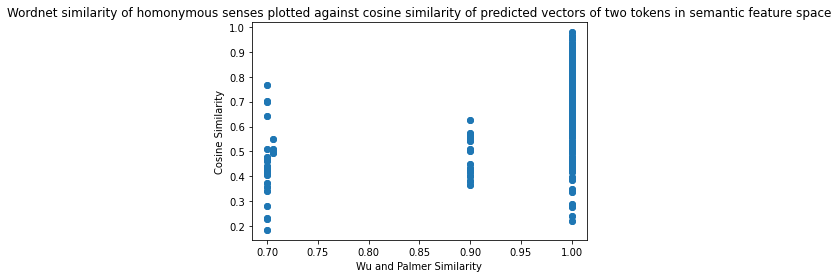

In [158]:
"""
do the correlation:
"""
import matplotlib.pyplot as plt

pyplot.scatter
pyplot.show()

plt.scatter(wup_sims, cossine_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

In [159]:
# calculate Pearson's correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr


corr, p = pearsonr(wup_sims, cossine_sims)
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(wup_sims, cossine_sims)
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))

Pearsons correlation: 0.483, p-value: 1.0079845463672174e-31
Spearmans correlation: 0.506, p-value: 4.008131005337109e-35


In [160]:
print (len(wup_sims))

520


# Do the same analysis for single-prototype model

Pearsons correlation: 0.567, p-value: 1.1948935320905846e-45
Spearmans correlation: 0.525, p-value: 3.035422467454594e-38


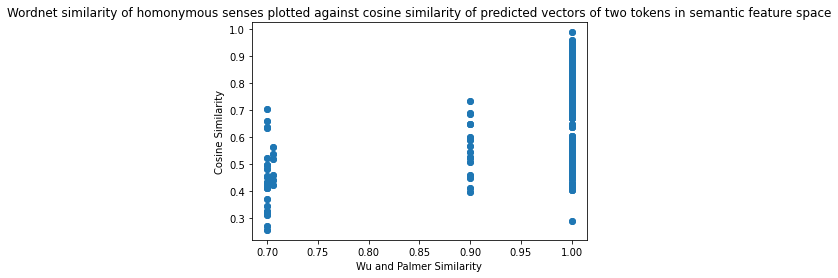

In [161]:
wup_sims = []
cossine_sims = []

for index, row in df.iterrows():
    word = row.label
    
    # select other examples of this token
    othertokens = df[df.label == word]
    # filter out the token itself
    othertokens = othertokens[othertokens.index != index]
    #print(othertokens)
    
    for index, otherword in othertokens.iterrows():
        # find the wordnet distance between these two wordnet senses
        synset1 = row.lemma.synset()
        synset2 = otherword.lemma.synset()
        
        wup_sim = synset1.wup_similarity(synset2)
        wup_sims.append(wup_sim)
        cossim = 1 - cosine(row.single_prototype_model_preds, otherword.single_prototype_model_preds)
        cossine_sims.append(cossim)
        #print(synset1)
        #print(synset2)
        #print(wup_sim)
        #print(cossim)

# calculate Pearson's correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr


corr, p = pearsonr(wup_sims, cossine_sims)
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(wup_sims, cossine_sims)
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))  

"""
do the correlation:
"""
import matplotlib.pyplot as plt

pyplot.scatter
pyplot.show()

plt.scatter(wup_sims, cossine_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

# Run the analysis for the non-contextual model (trained on GloVe)

Here we expect to see no correlation, because the model should be making the same prediction for every token of a word form, irrespective of the surrounding context

In [162]:
"""
first we need to make the predictions, which we havent generated yet. we already have a trained model, called 'glove_model'
"""

correlations = []
cosines = []
top_k_precs = []
n = 0

glove_model_predictions = []

for cue_word, lemma, context in data:
    n +=1
    singular = lemma.name()
    plural = pluralize(singular)

    gold_vector = norms.get_feature_vector(singular)
    gold_feats = norms.get_features(singular)
    k = len(gold_feats)



    try:
        predicted_vector = glove_model.predict(singular)
        top_k =  glove_model.predict_top_n_features(singular, k)
    except:
        predicted_vector = glove_model.predict(plural)
        top_k =  glove_model.predict_top_n_features(plural, k)

    glove_model_predictions.append(predicted_vector)
    cos = 1 - cosine(predicted_vector, gold_vector)
    cosines.append(cos)      

    #num_in_top_k = len(set(top_k).intersection(set(gold_feats)))
    #top_k_prec = num_in_top_k / k
    #top_k_precs.append(top_k_prec)

    corr, p = spearmanr(predicted_vector, gold_vector)
    correlations.append(corr)

    #print("cosine: %f" % cos)
    #print("precison: %f" % prec)
    #print("correlation: %f" % corr)
    #print("top k acc: %f" % top_k_prec)

print("Average cosine between gold and predicted feature norms: %s" % np.average(cosines))
#print("average Percentage (%) of gold gold-standard features retrieved in the top 10 features of the predicted vector: ", top_10_prec)
#print("average Percentage (%) of gold gold-standard features retrieved in the top 20 features of the predicted vector: ", top_20_prec)
#print("Average % @k (derby metric)", np.average(top_k_precs))
#print("Percentage (%) of test items that retrieve their gold-standard vector in the top 10 neighbours of their predicted vector: %f" % top_20_acc)
print("correlation between gold and predicted vectors: %s " % np.average(correlations))

print("total number of predictions: ", n)


df['glove_predictions'] = glove_model_predictions

#df


Average cosine between gold and predicted feature norms: 0.2970614465680318
correlation between gold and predicted vectors: 0.087274661537174 
total number of predictions:  55


Pearsons correlation: nan, p-value: nan
Spearmans correlation: nan, p-value: nan


/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


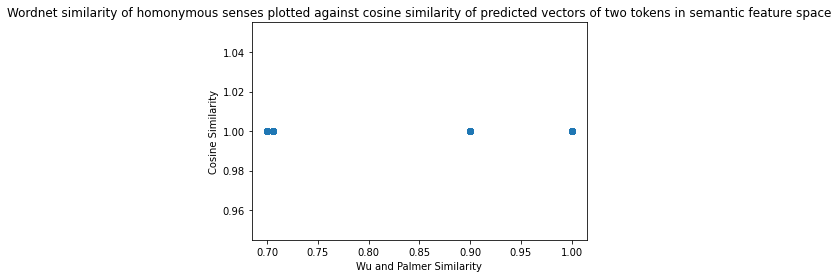

In [163]:
wup_sims = []
cossine_sims = []

for index, row in df.iterrows():
    word = row.label
    
    # select other examples of this token
    othertokens = df[df.label == word]
    # filter out the token itself
    othertokens = othertokens[othertokens.index != index]
    #print(othertokens)
    
    for index, otherword in othertokens.iterrows():
        # find the wordnet distance between these two wordnet senses
        synset1 = row.lemma.synset()
        synset2 = otherword.lemma.synset()
        
        wup_sim = synset1.wup_similarity(synset2)
        wup_sims.append(wup_sim)
        cossim = 1- cosine(row.glove_predictions, otherword.glove_predictions)
        cossine_sims.append(cossim)
        #print(synset1)
        #print(synset2)
        #print(wup_sim)
        #print(cossim)

# calculate Pearson's correlation
from scipy.stats import pearsonr
from scipy.stats import spearmanr


corr, p = pearsonr(wup_sims, cossine_sims)
print('Pearsons correlation: %.3f, p-value: %s'  % (corr, p))

corr, p = spearmanr(wup_sims, cossine_sims)
print('Spearmans correlation: %.3f, p-value: %s'  % (corr, p))  

"""
do the correlation:
"""
import matplotlib.pyplot as plt

pyplot.scatter
pyplot.show()

plt.scatter(wup_sims, cossine_sims)
plt.title("Wordnet similarity of homonymous senses plotted against cosine similarity of predicted vectors of two tokens in semantic feature space")
plt.xlabel("Wu and Palmer Similarity")
plt.ylabel("Cosine Similarity")
plt.show()

In [164]:
embeddings_list = []
word_indexer = Indexer()
with open("data/glove.6B/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_list.append([vector])

        #print(embeddings_dict)
        #raise Exception("hfelfnl")
        word_indexer.add_and_get_index(word)

embs = MultiProtoTypeEmbeddings(word_indexer, np.array(embeddings_list), 0, 1)
